In [1]:

import numpy as np
import pandas as pd
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import metrics
from collections import Counter
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.sklearn import metrics

#from common_utils import compute_metrics

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]



#Load the data
adult_data = pd.read_csv('C:/Users/thano/Υπολογιστής/ΠΤΥΧΙΑΚΗ/DATASETS/adult.csv',sep= ',', header= 0)

In [2]:
print ("Dataset Lenght:: ", len(adult_data))
print ("Dataset Shape:: ", adult_data.shape)
#adult_data.sample(50)


print ("Rows     : " ,adult_data.isnull().shape[0])
print ("Columns  : " ,adult_data.isnull().shape[1])
print ("\nMissing values :  ", adult_data.isnull().sum().values.sum())



Dataset Lenght::  32561
Dataset Shape::  (32561, 15)
Rows     :  32561
Columns  :  15

Missing values :   0


In [3]:
#Remove Netherlands
adult_data.drop(211,axis=0,inplace=True)

In [4]:
#remove column 'fnlwgt' because it's not strongly connected to protected attributes
adult_data = adult_data.drop("fnlwgt", axis=1)
#adult_data = adult_data.drop("capital.gain", axis=1)

In [5]:
# rename the other values except White value in race column as Other
adult_data['race']= adult_data['race'].replace(['Black','Asian-Pac-Islander', 'Amer-Indian-Eskimo'], 'Other')
adult_data.head(10)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,Some-college,10,Widowed,?,Unmarried,Other,Female,0,4356,40,United-States,<=50K
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
7,74,State-gov,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
8,68,Federal-gov,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
9,41,Private,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K


In [6]:
adult_data = adult_data[['age','education.num','capital.gain','capital.loss','hours.per.week','education','marital.status', 'occupation', 'relationship', 'race','sex', 'native.country', 'income','workclass']]
adult_data.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income,workclass
0,90,9,0,4356,40,HS-grad,Widowed,?,Not-in-family,White,Female,United-States,<=50K,?
1,82,9,0,4356,18,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K,Private
2,66,10,0,4356,40,Some-college,Widowed,?,Unmarried,Other,Female,United-States,<=50K,?
3,54,4,0,3900,40,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K,Private
4,41,10,0,3900,40,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K,Private


In [7]:
adult_data = adult_data.replace('?', np.nan)
adult_data.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income,workclass
0,90,9,0,4356,40,HS-grad,Widowed,NaN,Not-in-family,White,Female,United-States,<=50K,NaN
1,82,9,0,4356,18,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K,Private
2,66,10,0,4356,40,Some-college,Widowed,NaN,Unmarried,Other,Female,United-States,<=50K,NaN
3,54,4,0,3900,40,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K,Private
4,41,10,0,3900,40,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K,Private


In [8]:
# select all categorical variables
adult_data_categorical = adult_data.select_dtypes(include=['object'])
adult_data_categorical.head()

,education,marital.status,occupation,relationship,race,sex,native.country,income,workclass
0,HS-grad,Widowed,NaN,Not-in-family,White,Female,United-States,<=50K,NaN
1,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K,Private
2,Some-college,Widowed,NaN,Unmarried,Other,Female,United-States,<=50K,NaN
3,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K,Private
4,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K,Private


In [9]:
# To be changed!!! Better one hot encoding than label encoder
numeric_subset = adult_data.select_dtypes('number')
categorical_subset = adult_data.select_dtypes('object')

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset[categorical_subset.columns.drop("income")])

In [10]:
categorical_subset.head()

,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,...,native.country_Vietnam,native.country_Yugoslavia,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
#label encoding for categorical values but not for missing values
le = preprocessing.LabelEncoder()
adult_data_categorical = adult_data_categorical.apply(lambda series: pd.Series(le.fit_transform(series[series.notnull()]),index=series[series.notnull()].index))
adult_data_categorical.head()

,education,marital.status,occupation,relationship,race,sex,native.country,income,workclass
0,11,6,NaN,1,1,0,37.0,0,NaN
1,11,6,3.0,1,1,0,37.0,0,3.0
2,15,6,NaN,4,0,0,37.0,0,NaN
3,5,0,6.0,4,1,0,37.0,0,3.0
4,15,5,9.0,3,1,0,37.0,0,3.0


In [11]:
#Drop earlier duplicate columns which had categorical values and concat with new labelled categories (cd function)
adult_data = adult_data.drop(adult_data_categorical.columns,axis=1)
adult_data = pd.concat([adult_data,adult_data_categorical],axis=1)
adult_data.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income,workclass
0,90,9,0,4356,40,11,6,NaN,1,1,0,37.0,0,NaN
1,82,9,0,4356,18,11,6,3.0,1,1,0,37.0,0,3.0
2,66,10,0,4356,40,15,6,NaN,4,0,0,37.0,0,NaN
3,54,4,0,3900,40,5,0,6.0,4,1,0,37.0,0,3.0
4,41,10,0,3900,40,15,5,9.0,3,1,0,37.0,0,3.0


In [12]:
#put the workclass column in test data
adult_test = adult_data[adult_data['workclass'].isnull()]
adult_test

,age,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income,workclass
0,90,9,0,4356,40,11,6,NaN,1,1,0,37.0,0,NaN
2,66,10,0,4356,40,15,6,NaN,4,0,0,37.0,0,NaN
14,51,16,0,2824,40,10,4,NaN,1,1,1,37.0,1,NaN
24,61,9,0,2603,32,11,2,NaN,0,1,1,37.0,0,NaN
44,71,9,0,2489,15,11,2,NaN,0,1,1,37.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32533,35,13,0,0,55,9,2,NaN,5,1,0,37.0,1,NaN
32534,30,13,0,0,99,9,4,NaN,1,0,0,37.0,0,NaN
32541,71,16,0,0,10,10,2,NaN,0,1,1,37.0,1,NaN
32543,41,9,0,0,32,11,5,NaN,1,0,0,37.0,0,NaN


In [13]:
#drop workclass category
X_test = adult_test.drop('workclass',axis=1)
X_test

,age,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income
0,90,9,0,4356,40,11,6,NaN,1,1,0,37.0,0
2,66,10,0,4356,40,15,6,NaN,4,0,0,37.0,0
14,51,16,0,2824,40,10,4,NaN,1,1,1,37.0,1
24,61,9,0,2603,32,11,2,NaN,0,1,1,37.0,0
44,71,9,0,2489,15,11,2,NaN,0,1,1,37.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32533,35,13,0,0,55,9,2,NaN,5,1,0,37.0,1
32534,30,13,0,0,99,9,4,NaN,1,0,0,37.0,0
32541,71,16,0,0,10,10,2,NaN,0,1,1,37.0,1
32543,41,9,0,0,32,11,5,NaN,1,0,0,37.0,0


In [14]:
#train data without missing values
adult_train = adult_data.dropna(subset = ['workclass'])
adult_train

,age,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income,workclass
1,82,9,0,4356,18,11,6,3.0,1,1,0,37.0,0,3.0
3,54,4,0,3900,40,5,0,6.0,4,1,0,37.0,0,3.0
4,41,10,0,3900,40,15,5,9.0,3,1,0,37.0,0,3.0
5,34,9,0,3770,45,11,0,7.0,4,1,0,37.0,0,3.0
6,38,6,0,3770,40,0,5,0.0,4,1,1,37.0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,10,0,0,40,15,4,10.0,1,1,1,37.0,0,3.0
32557,27,12,0,0,38,7,2,12.0,5,1,0,37.0,0,3.0
32558,40,9,0,0,40,11,2,6.0,0,1,1,37.0,1,3.0
32559,58,9,0,0,40,11,6,0.0,4,1,0,37.0,0,3.0


In [15]:
#drop workclas from x train
X_train = adult_train.drop('workclass',axis=1)
X_train

,age,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income
1,82,9,0,4356,18,11,6,3.0,1,1,0,37.0,0
3,54,4,0,3900,40,5,0,6.0,4,1,0,37.0,0
4,41,10,0,3900,40,15,5,9.0,3,1,0,37.0,0
5,34,9,0,3770,45,11,0,7.0,4,1,0,37.0,0
6,38,6,0,3770,40,0,5,0.0,4,1,1,37.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,10,0,0,40,15,4,10.0,1,1,1,37.0,0
32557,27,12,0,0,38,7,2,12.0,5,1,0,37.0,0
32558,40,9,0,0,40,11,2,6.0,0,1,1,37.0,1
32559,58,9,0,0,40,11,6,0.0,4,1,0,37.0,0


In [16]:
y_train = adult_train['workclass']
y_train

1        3.0
3        3.0
4        3.0
5        3.0
6        3.0
        ... 
32556    3.0
32557    3.0
32558    3.0
32559    3.0
32560    3.0
Name: workclass, Length: 30724, dtype: float64

In [17]:
#HistGradient classifier (only classifier that works with NaN values)
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier().fit(X_train, y_train)

In [18]:
y_pred = clf.predict(X_test)

In [19]:
workclassMissing = pd.DataFrame(y_pred)
workclassMissing

,0
0,3.0
1,2.0
2,3.0
3,3.0
4,3.0
...,...
1831,3.0
1832,2.0
1833,7.0
1834,2.0


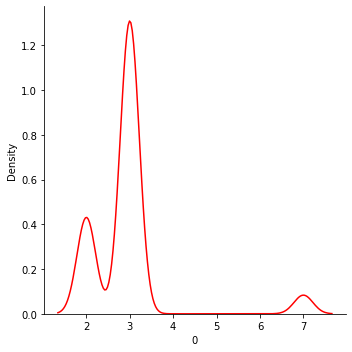

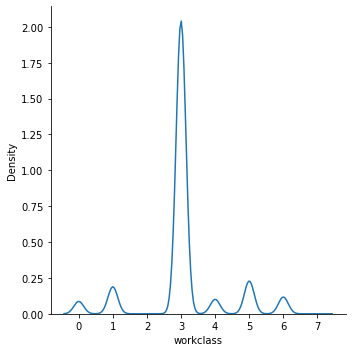

In [20]:
#visualize workclassMissing and workclass nonMissing 
sns.set
sns.displot(workclassMissing, x=0, kind = 'kde', color = 'r')
sns.displot(adult_data, x=y_train, kind ='kde')
 
# visualizing illustration
plt.show()

In [21]:
X_test['workclass'] = y_pred
X_test

,age,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income,workclass
0,90,9,0,4356,40,11,6,NaN,1,1,0,37.0,0,3.0
2,66,10,0,4356,40,15,6,NaN,4,0,0,37.0,0,2.0
14,51,16,0,2824,40,10,4,NaN,1,1,1,37.0,1,3.0
24,61,9,0,2603,32,11,2,NaN,0,1,1,37.0,0,3.0
44,71,9,0,2489,15,11,2,NaN,0,1,1,37.0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32533,35,13,0,0,55,9,2,NaN,5,1,0,37.0,1,3.0
32534,30,13,0,0,99,9,4,NaN,1,0,0,37.0,0,2.0
32541,71,16,0,0,10,10,2,NaN,0,1,1,37.0,1,7.0
32543,41,9,0,0,32,11,5,NaN,1,0,0,37.0,0,2.0


In [22]:
adult1 = pd.concat([adult_train,X_test])

In [23]:
adult1.sort_index(inplace=True)
adult1.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income,workclass
0,90,9,0,4356,40,11,6,NaN,1,1,0,37.0,0,3.0
1,82,9,0,4356,18,11,6,3.0,1,1,0,37.0,0,3.0
2,66,10,0,4356,40,15,6,NaN,4,0,0,37.0,0,2.0
3,54,4,0,3900,40,5,0,6.0,4,1,0,37.0,0,3.0
4,41,10,0,3900,40,15,5,9.0,3,1,0,37.0,0,3.0


In [24]:
#--------------------------------------------END OF 1ST LOOP---------------------------------------------------------------

In [25]:
adult1 = adult1[['age','workclass','education.num','capital.gain','capital.loss','hours.per.week','education','marital.status', 'relationship', 'race','sex', 'native.country', 'income', 'occupation']]
adult1.head()

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,relationship,race,sex,native.country,income,occupation
0,90,3.0,9,0,4356,40,11,6,1,1,0,37.0,0,NaN
1,82,3.0,9,0,4356,18,11,6,1,1,0,37.0,0,3.0
2,66,2.0,10,0,4356,40,15,6,4,0,0,37.0,0,NaN
3,54,3.0,4,0,3900,40,5,0,4,1,0,37.0,0,6.0
4,41,3.0,10,0,3900,40,15,5,3,1,0,37.0,0,9.0


In [26]:
adult1_test = adult1[adult1['occupation'].isnull()]
adult1_test

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,relationship,race,sex,native.country,income,occupation
0,90,3.0,9,0,4356,40,11,6,1,1,0,37.0,0,NaN
2,66,2.0,10,0,4356,40,15,6,4,0,0,37.0,0,NaN
14,51,3.0,16,0,2824,40,10,4,1,1,1,37.0,1,NaN
24,61,3.0,9,0,2603,32,11,2,0,1,1,37.0,0,NaN
44,71,3.0,9,0,2489,15,11,2,0,1,1,37.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32533,35,3.0,13,0,0,55,9,2,5,1,0,37.0,1,NaN
32534,30,2.0,13,0,0,99,9,4,1,0,0,37.0,0,NaN
32541,71,7.0,16,0,0,10,10,2,0,1,1,37.0,1,NaN
32543,41,2.0,9,0,0,32,11,5,1,0,0,37.0,0,NaN


In [27]:
X1_test = adult1_test.drop('occupation',axis=1)
X1_test

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,relationship,race,sex,native.country,income
0,90,3.0,9,0,4356,40,11,6,1,1,0,37.0,0
2,66,2.0,10,0,4356,40,15,6,4,0,0,37.0,0
14,51,3.0,16,0,2824,40,10,4,1,1,1,37.0,1
24,61,3.0,9,0,2603,32,11,2,0,1,1,37.0,0
44,71,3.0,9,0,2489,15,11,2,0,1,1,37.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32533,35,3.0,13,0,0,55,9,2,5,1,0,37.0,1
32534,30,2.0,13,0,0,99,9,4,1,0,0,37.0,0
32541,71,7.0,16,0,0,10,10,2,0,1,1,37.0,1
32543,41,2.0,9,0,0,32,11,5,1,0,0,37.0,0


In [28]:
adult1_train = adult1.dropna(subset = ['occupation'])
adult1_train

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,relationship,race,sex,native.country,income,occupation
1,82,3.0,9,0,4356,18,11,6,1,1,0,37.0,0,3.0
3,54,3.0,4,0,3900,40,5,0,4,1,0,37.0,0,6.0
4,41,3.0,10,0,3900,40,15,5,3,1,0,37.0,0,9.0
5,34,3.0,9,0,3770,45,11,0,4,1,0,37.0,0,7.0
6,38,3.0,6,0,3770,40,0,5,4,1,1,37.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,3.0,10,0,0,40,15,4,1,1,1,37.0,0,10.0
32557,27,3.0,12,0,0,38,7,2,5,1,0,37.0,0,12.0
32558,40,3.0,9,0,0,40,11,2,0,1,1,37.0,1,6.0
32559,58,3.0,9,0,0,40,11,6,4,1,0,37.0,0,0.0


In [29]:
X1_train = adult1_train.drop('occupation',axis=1)
X1_train

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,relationship,race,sex,native.country,income
1,82,3.0,9,0,4356,18,11,6,1,1,0,37.0,0
3,54,3.0,4,0,3900,40,5,0,4,1,0,37.0,0
4,41,3.0,10,0,3900,40,15,5,3,1,0,37.0,0
5,34,3.0,9,0,3770,45,11,0,4,1,0,37.0,0
6,38,3.0,6,0,3770,40,0,5,4,1,1,37.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,3.0,10,0,0,40,15,4,1,1,1,37.0,0
32557,27,3.0,12,0,0,38,7,2,5,1,0,37.0,0
32558,40,3.0,9,0,0,40,11,2,0,1,1,37.0,1
32559,58,3.0,9,0,0,40,11,6,4,1,0,37.0,0


In [30]:
y1_train = adult1_train['occupation']
y1_train

1         3.0
3         6.0
4         9.0
5         7.0
6         0.0
         ... 
32556    10.0
32557    12.0
32558     6.0
32559     0.0
32560     0.0
Name: occupation, Length: 30717, dtype: float64

In [31]:
#HistGradient classifier (only classifier that works with NaN values)
from sklearn.ensemble import HistGradientBoostingClassifier
clf1 = HistGradientBoostingClassifier().fit(X1_train, y1_train)

In [32]:
y1_pred = clf1.predict(X1_test)

In [33]:
#convert to Dataframe in order to visualize
occupationMissing = pd.DataFrame(y1_pred)
occupationMissing

,0
0,0.0
1,0.0
2,9.0
3,2.0
4,11.0
...,...
1838,3.0
1839,9.0
1840,9.0
1841,7.0


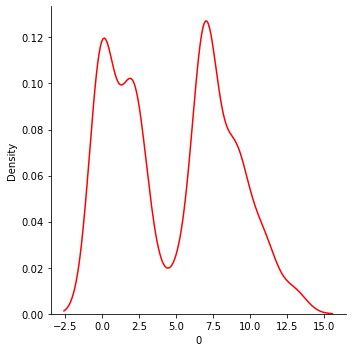

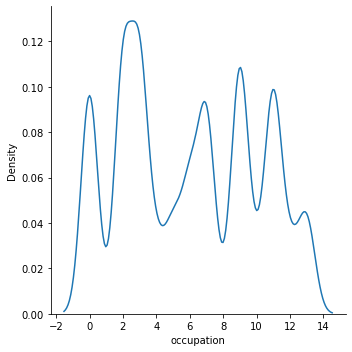

In [34]:
#visualize occupation and occupation nonMissing 
sns.set
sns.displot(occupationMissing, x=0, kind = 'kde', color = 'r')
sns.displot(adult1, x=y1_train, kind ='kde')
 
# visualizing illustration
plt.show()

In [35]:
X1_test['occupation'] = y1_pred
X1_test

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,relationship,race,sex,native.country,income,occupation
0,90,3.0,9,0,4356,40,11,6,1,1,0,37.0,0,0.0
2,66,2.0,10,0,4356,40,15,6,4,0,0,37.0,0,0.0
14,51,3.0,16,0,2824,40,10,4,1,1,1,37.0,1,9.0
24,61,3.0,9,0,2603,32,11,2,0,1,1,37.0,0,2.0
44,71,3.0,9,0,2489,15,11,2,0,1,1,37.0,0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32533,35,3.0,13,0,0,55,9,2,5,1,0,37.0,1,3.0
32534,30,2.0,13,0,0,99,9,4,1,0,0,37.0,0,9.0
32541,71,7.0,16,0,0,10,10,2,0,1,1,37.0,1,9.0
32543,41,2.0,9,0,0,32,11,5,1,0,0,37.0,0,7.0


In [36]:
adult2 = pd.concat([adult1_train,X1_test])
adult2.head(10)

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,relationship,race,sex,native.country,income,occupation
1,82,3.0,9,0,4356,18,11,6,1,1,0,37.0,0,3.0
3,54,3.0,4,0,3900,40,5,0,4,1,0,37.0,0,6.0
4,41,3.0,10,0,3900,40,15,5,3,1,0,37.0,0,9.0
5,34,3.0,9,0,3770,45,11,0,4,1,0,37.0,0,7.0
6,38,3.0,6,0,3770,40,0,5,4,1,1,37.0,0,0.0
7,74,6.0,16,0,3683,20,10,4,2,1,0,37.0,1,9.0
8,68,0.0,9,0,3683,40,11,0,1,1,0,37.0,0,9.0
9,41,3.0,10,0,3004,60,15,4,4,1,1,NaN,1,2.0
10,45,3.0,16,0,3004,35,10,0,4,0,0,37.0,1,9.0
11,38,5.0,15,0,2824,45,14,4,1,1,1,37.0,1,9.0


In [37]:
adult2.sort_index(inplace=True)
adult2.head()

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,relationship,race,sex,native.country,income,occupation
0,90,3.0,9,0,4356,40,11,6,1,1,0,37.0,0,0.0
1,82,3.0,9,0,4356,18,11,6,1,1,0,37.0,0,3.0
2,66,2.0,10,0,4356,40,15,6,4,0,0,37.0,0,0.0
3,54,3.0,4,0,3900,40,5,0,4,1,0,37.0,0,6.0
4,41,3.0,10,0,3900,40,15,5,3,1,0,37.0,0,9.0


In [38]:
#------------------------------------------- END OF 2ND LOOP -------------------------------------------------------------------

In [39]:
adult_check_missing = (adult2.isnull()).sum()
adult_check_missing

age                 0
workclass           0
education.num       0
capital.gain        0
capital.loss        0
hours.per.week      0
education           0
marital.status      0
relationship        0
race                0
sex                 0
native.country    583
income              0
occupation          0
dtype: int64

In [40]:
adult2 = adult2[['age','workclass','education.num','capital.gain','capital.loss','hours.per.week','education','marital.status', 'occupation', 'relationship', 'race','sex', 'income', 'native.country']]
adult2.head()

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,income,native.country
0,90,3.0,9,0,4356,40,11,6,0.0,1,1,0,0,37.0
1,82,3.0,9,0,4356,18,11,6,3.0,1,1,0,0,37.0
2,66,2.0,10,0,4356,40,15,6,0.0,4,0,0,0,37.0
3,54,3.0,4,0,3900,40,5,0,6.0,4,1,0,0,37.0
4,41,3.0,10,0,3900,40,15,5,9.0,3,1,0,0,37.0


In [41]:
adult2_test = adult2[adult2['native.country'].isnull()]
adult2_test

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,income,native.country
9,41,3.0,10,0,3004,60,15,4,2.0,4,1,1,1,NaN
18,22,3.0,12,0,2824,40,7,4,5.0,1,0,1,1,NaN
65,60,4.0,11,0,2415,70,8,2,6.0,0,1,1,1,NaN
86,39,5.0,15,0,2415,50,14,2,9.0,0,1,1,1,NaN
87,43,0.0,15,0,2415,55,14,2,9.0,0,0,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32459,44,4.0,14,0,0,50,12,2,11.0,0,1,1,1,NaN
32476,58,4.0,16,0,0,99,10,4,9.0,1,1,0,0,NaN
32498,42,5.0,9,0,0,50,11,0,11.0,3,1,1,0,NaN
32515,39,3.0,9,0,0,45,11,2,9.0,0,1,1,1,NaN


In [42]:
X2_test = adult2_test.drop('native.country',axis=1)
X2_test

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,income
9,41,3.0,10,0,3004,60,15,4,2.0,4,1,1,1
18,22,3.0,12,0,2824,40,7,4,5.0,1,0,1,1
65,60,4.0,11,0,2415,70,8,2,6.0,0,1,1,1
86,39,5.0,15,0,2415,50,14,2,9.0,0,1,1,1
87,43,0.0,15,0,2415,55,14,2,9.0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32459,44,4.0,14,0,0,50,12,2,11.0,0,1,1,1
32476,58,4.0,16,0,0,99,10,4,9.0,1,1,0,0
32498,42,5.0,9,0,0,50,11,0,11.0,3,1,1,0
32515,39,3.0,9,0,0,45,11,2,9.0,0,1,1,1


In [43]:
adult2_train = adult2.dropna(subset = ['native.country'])
adult2_train

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,income,native.country
0,90,3.0,9,0,4356,40,11,6,0.0,1,1,0,0,37.0
1,82,3.0,9,0,4356,18,11,6,3.0,1,1,0,0,37.0
2,66,2.0,10,0,4356,40,15,6,0.0,4,0,0,0,37.0
3,54,3.0,4,0,3900,40,5,0,6.0,4,1,0,0,37.0
4,41,3.0,10,0,3900,40,15,5,9.0,3,1,0,0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,3.0,10,0,0,40,15,4,10.0,1,1,1,0,37.0
32557,27,3.0,12,0,0,38,7,2,12.0,5,1,0,0,37.0
32558,40,3.0,9,0,0,40,11,2,6.0,0,1,1,1,37.0
32559,58,3.0,9,0,0,40,11,6,0.0,4,1,0,0,37.0


In [44]:
X2_train = adult2_train.drop('native.country',axis=1)
X2_train

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,income
0,90,3.0,9,0,4356,40,11,6,0.0,1,1,0,0
1,82,3.0,9,0,4356,18,11,6,3.0,1,1,0,0
2,66,2.0,10,0,4356,40,15,6,0.0,4,0,0,0
3,54,3.0,4,0,3900,40,5,0,6.0,4,1,0,0
4,41,3.0,10,0,3900,40,15,5,9.0,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,3.0,10,0,0,40,15,4,10.0,1,1,1,0
32557,27,3.0,12,0,0,38,7,2,12.0,5,1,0,0
32558,40,3.0,9,0,0,40,11,2,6.0,0,1,1,1
32559,58,3.0,9,0,0,40,11,6,0.0,4,1,0,0


In [45]:
y2_train = adult2_train['native.country']
y2_train

0        37.0
1        37.0
2        37.0
3        37.0
4        37.0
         ... 
32556    37.0
32557    37.0
32558    37.0
32559    37.0
32560    37.0
Name: native.country, Length: 31977, dtype: float64

In [46]:
#HistGradient classifier (only classifier that works with NaN values)
from sklearn.ensemble import HistGradientBoostingClassifier
clf2 = HistGradientBoostingClassifier().fit(X2_train, y2_train)

In [47]:
y2_pred = clf2.predict(X2_test)

In [48]:
#convert to Dataframe in order to visualize
nativeMissing = pd.DataFrame(y2_pred)
nativeMissing 

,0
0,37.0
1,33.0
2,37.0
3,37.0
4,17.0
...,...
578,37.0
579,33.0
580,37.0
581,37.0


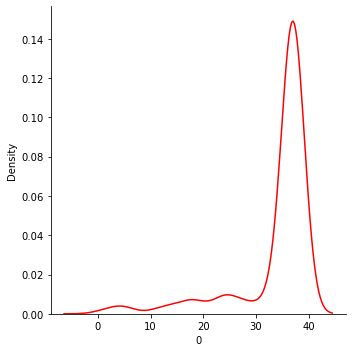

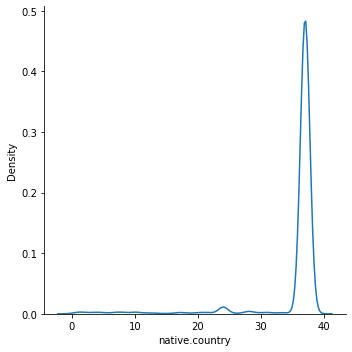

In [49]:
#visualize native-countryMissing and native-country nonMissing 
sns.set
sns.displot(nativeMissing, x=0, kind = 'kde', color = 'r')
sns.displot(adult2, x=y2_train, kind ='kde')
 
# visualizing illustration
plt.show()

In [50]:
X2_test['native.country'] = y2_pred
X2_test

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,income,native.country
9,41,3.0,10,0,3004,60,15,4,2.0,4,1,1,1,37.0
18,22,3.0,12,0,2824,40,7,4,5.0,1,0,1,1,33.0
65,60,4.0,11,0,2415,70,8,2,6.0,0,1,1,1,37.0
86,39,5.0,15,0,2415,50,14,2,9.0,0,1,1,1,37.0
87,43,0.0,15,0,2415,55,14,2,9.0,0,0,1,1,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32459,44,4.0,14,0,0,50,12,2,11.0,0,1,1,1,37.0
32476,58,4.0,16,0,0,99,10,4,9.0,1,1,0,0,33.0
32498,42,5.0,9,0,0,50,11,0,11.0,3,1,1,0,37.0
32515,39,3.0,9,0,0,45,11,2,9.0,0,1,1,1,37.0


In [51]:
adult3 = pd.concat([adult2_train,X2_test])
adult3.head(10)

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,income,native.country
0,90,3.0,9,0,4356,40,11,6,0.0,1,1,0,0,37.0
1,82,3.0,9,0,4356,18,11,6,3.0,1,1,0,0,37.0
2,66,2.0,10,0,4356,40,15,6,0.0,4,0,0,0,37.0
3,54,3.0,4,0,3900,40,5,0,6.0,4,1,0,0,37.0
4,41,3.0,10,0,3900,40,15,5,9.0,3,1,0,0,37.0
5,34,3.0,9,0,3770,45,11,0,7.0,4,1,0,0,37.0
6,38,3.0,6,0,3770,40,0,5,0.0,4,1,1,0,37.0
7,74,6.0,16,0,3683,20,10,4,9.0,2,1,0,1,37.0
8,68,0.0,9,0,3683,40,11,0,9.0,1,1,0,0,37.0
10,45,3.0,16,0,3004,35,10,0,9.0,4,0,0,1,37.0


In [52]:
adult3.sort_index(inplace=True)
adult3.head()

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,income,native.country
0,90,3.0,9,0,4356,40,11,6,0.0,1,1,0,0,37.0
1,82,3.0,9,0,4356,18,11,6,3.0,1,1,0,0,37.0
2,66,2.0,10,0,4356,40,15,6,0.0,4,0,0,0,37.0
3,54,3.0,4,0,3900,40,5,0,6.0,4,1,0,0,37.0
4,41,3.0,10,0,3900,40,15,5,9.0,3,1,0,0,37.0


In [53]:
adult_final = adult3[['age','workclass','education.num','capital.gain','capital.loss','hours.per.week','education','marital.status', 'occupation', 'relationship', 'race','sex', 'native.country', 'income']]
adult_final

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income
0,90,3.0,9,0,4356,40,11,6,0.0,1,1,0,37.0,0
1,82,3.0,9,0,4356,18,11,6,3.0,1,1,0,37.0,0
2,66,2.0,10,0,4356,40,15,6,0.0,4,0,0,37.0,0
3,54,3.0,4,0,3900,40,5,0,6.0,4,1,0,37.0,0
4,41,3.0,10,0,3900,40,15,5,9.0,3,1,0,37.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,3.0,10,0,0,40,15,4,10.0,1,1,1,37.0,0
32557,27,3.0,12,0,0,38,7,2,12.0,5,1,0,37.0,0
32558,40,3.0,9,0,0,40,11,2,6.0,0,1,1,37.0,1
32559,58,3.0,9,0,0,40,11,6,0.0,4,1,0,37.0,0


In [73]:
privileged_groups = [{'sex' :1}]
unprivileged_groups = [{'sex' :0}]
#privileged_groups = [{'race' :1}]
#unprivileged_groups = [{'race' : 0}]

In [74]:
#Convert to BinaryLabelDataset to compute fair metrics
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= adult_final,
    label_names = ['income'],
    protected_attribute_names=['sex'])

In [75]:
#SPD calculation
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
# Load and create explainers

text_exp_otr = MetricTextExplainer(metric_orig_train)
# Print statistical parity difference
print(text_exp_otr.statistical_parity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.1962658243220613


In [76]:
# Putting independent variables/features to X
x = adult_final.drop('income',axis=1)
# Putting response/dependent variable/feature to y
Y = adult_final['income']

In [77]:
# Splitting the data into train and test
x_train,x_test,Y_train,Y_test = train_test_split(x,Y,test_size=0.25)


In [78]:
models = []
#models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('HGB', HistGradientBoostingClassifier()))

In [79]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [80]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    cv_results = cross_val_score(model, x_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.836200 (0.004083)
NB: 0.802334 (0.005235)
CART: 0.815152 (0.005915)
RF: 0.850082 (0.004138)
SVM: 0.803112 (0.004282)
HGB: 0.873219 (0.004288)


In [1]:
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(x_train,Y_train)
# predictions
rfc_predict = rfc.predict(x_test)

NameError: name 'RandomForestClassifier' is not defined

In [81]:
#Hist_Based model training
hgb_classifier = HistGradientBoostingClassifier()
hgb_classifier.fit(x_train,Y_train)
y_pred_hgb = hgb_classifier.predict(x_test)

In [82]:
#classification report and confussion matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, y_pred_hgb))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, y_pred_hgb))

=== Confusion Matrix ===
[[5828  359]
 [ 696 1257]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6187
           1       0.78      0.64      0.70      1953

    accuracy                           0.87      8140
   macro avg       0.84      0.79      0.81      8140
weighted avg       0.87      0.87      0.87      8140



In [83]:
from sklearn import metrics
Sensitivity_recall = metrics.recall_score(Y_test, y_pred_hgb)
print({"Sensitivity":Sensitivity_recall})

{'Sensitivity': 0.6436251920122887}


In [84]:
x_test = pd.concat([x_test,Y_test],axis=1)
x_test

,age,workclass,education.num,capital.gain,capital.loss,hours.per.week,education,marital.status,occupation,relationship,race,sex,native.country,income
30676,28,3.0,6,0,0,40,0,2,13.0,0,1,1,37.0,0
10794,28,1.0,9,0,0,30,11,4,7.0,3,0,1,37.0,0
26484,73,7.0,9,0,0,15,11,2,2.0,0,1,1,37.0,0
23923,60,4.0,9,0,0,40,11,2,7.0,0,1,1,37.0,0
23028,53,4.0,16,0,0,40,10,2,9.0,0,1,1,37.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32063,48,4.0,10,0,0,45,15,0,4.0,1,1,1,37.0,0
10881,29,3.0,10,0,0,40,15,4,7.0,4,0,0,37.0,0
23698,64,3.0,10,0,0,10,15,6,3.0,1,1,0,37.0,0
26676,33,3.0,13,0,0,40,9,2,3.0,5,1,0,37.0,1


In [85]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= x_test,
    label_names=['income'],
    protected_attribute_names=['sex'])

In [86]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset, y_pred_hgb):
    dataset_pred = binaryLabelDataset.copy()
    dataset_pred.labels = y_pred_hgb
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset, y_pred_hgb)

{'statistical_parity_difference': -0.17976940897580948}

In [177]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = -0.100470


In [ ]:
rfc = RandomForestClassifier(n_estimators=600, max_depth=300, max_features='sqrt')
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())